# AlexNet论文复现
这是第一个非常成功的用于图像分类的 CNN，它导致了深度学习热潮的爆发，同时也是第一个成功使用 dropout 层的例子。

此实现使用 ILSVRC 2012 数据集，也称为“ImageNet 2012 数据集”。数据量巨大（138G！），但为了成功训练 AlexNet，需要这样大规模的数据集。由于 Tiny ImageNet 或 MNIST 的特征尺寸较小（图像无法适应输入尺寸 227 x 227），因此无法进行测试。

## 基本架构
<img src='img/AlexNet.png'>

## 关键特点

1. **共 8 层：5 层卷积层 + 3 层全连接层**
    - 相较于之前的LeNet更深、更复杂

2. **ReLU 激活函数**
    - 使用 ReLU 替代 Sigmoid/Tanh，提高训练速度，减少梯度消失问题

3. **卷积层与最大池化层**
    - 卷积层用于提取特征
    - 最大池化 (Max Pooling) 层减少空间尺寸和过拟合

4. **局部响应归一化 (LRN)**
    - 强化响应较强的神经元
    - 提高泛化能力提升泛化能力

5. **使用 Dropout**
    - 在全连接层使用 Dropout 减少过拟合
    - 随机丢弃部分神经元，增强模型鲁棒性

6. **数据增强**
    - 应用图像平移、翻转等技术扩充训练数据集
    - 提高模型的泛化能力

7. **使用大规模数据集 (ImageNet)**
    - 在 ImageNet 上训练，包含百万级图片和千级类别
    - 大规模数据为深度网络提供更强的学习能力

## 步骤：
1. **数据预处理与加载**
    - 数据增强（如随机裁剪、水平翻转）以提升泛化能力
    - 归一化 图像数据以加快训练收敛速度

2. **定义 AlexNet 模型**
    - 搭建8层网络结构（5个卷积层 + 3个全连接层）
    - 添加 ReLU 激活函数、LRN 层、Dropout 和 MaxPooling 层

3. **定义损失函数与优化器**
    - 使用 交叉熵损失函数 (CrossEntropyLoss)
    - 优化器选择 SGD+动量

4. **模型评估**
    - 使用测试数据集评估准确率
    - 绘制损失和准确率曲线以检查模型是否过拟合或欠拟合


### 1. 必要库的导入

### 📦 **导入必要的库**
在本部分，我们导入用于数据加载、模型构建和训练的必要库。
- `torch` 和 `torchvision` 用于深度学习框架。
- `PIL` 用于图像处理。
- `tqdm` 用于显示训练进度条，帮助观察训练进度。


In [1]:
import os
import sys
import csv
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset
from PIL import Image

# 获取当前文件的父目录
parent_dir = os.path.abspath(os.path.join(os.path.dirname('__file__'),'..'))
# 如果父目录不在 sys.path中，则添加
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
import utils
    
%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available()
                      else 'mps' if torch.mps.is_available()
                      else 'cpu')
print(torch.__version__)
print(device)

2.6.0
mps


### 2. 导入数据库并转换为DataLoader格式

### 🖼️ **数据预处理与增强**
在这一部分中，我们使用 `torchvision.transforms` 来对图像进行预处理：
- `Resize` 和 `CenterCrop`：调整图像大小以匹配模型输入。
- `ToTensor`：将图像转换为张量。
- `Normalize`：对像素值进行归一化，有助于模型更快收敛。

⚠️ **初学者提示**：
- 确保 `mean` 和 `std` 值与预训练模型使用的值一致。
- 输入图像的大小应与模型期望的输入大小匹配。

In [ ]:
transform = {'train':transforms.Compose([
                     transforms.RandomResizedCrop(224),             # 随机裁剪并缩放到224x224
                     transforms.RandomHorizontalFlip(),             # 随机水平翻转
                     transforms.ToTensor(),                         # 转为Tensor
                     transforms.Normalize(mean=[0.485, 0.456, 0.406],# 按ImageNet均值和标准差归一化
                                          std=[0.229, 0.224, 0.225])
    ]),
             'val':transforms.Compose([
                   transforms.Resize(256),                        # 短边缩放到256
                   transforms.CenterCrop(224),                    # 从中心裁剪224x224
                   transforms.ToTensor(),                         # 转为Tensor
                   transforms.Normalize(mean=[0.485, 0.456, 0.406],# 按ImageNet均值和标准差归一化
                                         std=[0.229, 0.224, 0.225])
             ]),
             'test':transforms.Compose([
                    transforms.Resize(256),                        # 短边缩放到256
                    transforms.CenterCrop(224),                    # 从中心裁剪224x224
                    transforms.ToTensor(),                         # 转为Tensor
                    transforms.Normalize(mean=[0.485, 0.456, 0.406],# 按ImageNet均值和标准差归一化
                                         std=[0.229, 0.224, 0.225])
    ])
}

In [ ]:
# 读取验证集的标签
val_labels = {}
with open('../Datasets/tiny-imagenet-200/val/val_annotations.txt') as f:
    for line in f:
        parts = line.strip().split('\t')
        filename, label = parts[0], parts[1]
        val_labels[filename] = label
print(val_labels['val_0.JPEG'])

In [ ]:
ImageNet_train = datasets.ImageFolder(root='../Datasets/tiny-imagenet-200/train',transform=transform['train'])
ImageNet_val = datasets.ImageFolder(root='../Datasets/tiny-imagenet-200/val',transform=transform['val'])
ImageNet_test = datasets.ImageFolder(root='../Datasets/tiny-imagenet-200/test',transform=transform['test'])

### 🚀 **数据加载器 (DataLoader) 设置**
这里我们使用 `DataLoader` 来批量加载数据。
- `batch_size`：每次输入模型的样本数量。
- `shuffle`：在每个 epoch 开始时打乱数据，提高模型泛化能力。
- `num_workers`：设置加载数据的子进程数量，数值取决于机器的 CPU 核数。

⚡ **初学者易错点**：
- 如果在 Windows 或 Jupyter Notebook 中遇到多进程加载问题，请尝试将 `num_workers=0`。
- 如果数据加载比预期慢，尝试调整 `num_workers` 或使用 `pin_memory=True`。

In [ ]:
batch_size = 64
num_workers = 4
ImageNet_train_iter = DataLoader(ImageNet_train,batch_size=batch_size,shuffle=True,num_workers=num_workers)
ImageNet_val_iter = DataLoader(ImageNet_val,batch_size=batch_size,shuffle=False,num_workers=num_workers)
ImageNet_test_iter = DataLoader(ImageNet_test,batch_size=batch_size,shuffle=False,num_workers=num_workers)

In [ ]:
img_train = next(iter(ImageNet_train_iter))
print(len(img_train))
print(img_train[0].shape)
print(img_train[1].shape)
print(img_train[1])

In [ ]:
img_val = next(iter(ImageNet_val_iter))
print(len(img_val))
print(img_val[0].shape)
print(img_val[1].shape)
print(img_val[1])

我们会发现这里的标签部分很奇怪，全都是0，这是因为val数据集并没有按照ImageFolder要求的格式进行整理，所以我们需要自己定义数据集！

In [2]:
# 3. 自定义验证集数据集
class TinyImageNetValDataset(Dataset):
    def __init__(self, img_dir, val_labels, transform=None):
        self.img_dir = img_dir
        self.img_dict = val_labels
        self.transform = transform
        self.classes = sorted(list(set(self.img_dict.values())))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.img_list = list(self.img_dict.keys())

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_name = self.img_list[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        label = self.class_to_idx[self.img_dict[img_name]]

        if self.transform:
            image = self.transform(image)
        return image, label

### 🚀 **数据加载器 (DataLoader) 设置**
这里我们使用 `DataLoader` 来批量加载数据。
- `batch_size`：每次输入模型的样本数量。
- `shuffle`：在每个 epoch 开始时打乱数据，提高模型泛化能力。
- `num_workers`：设置加载数据的子进程数量，数值取决于机器的 CPU 核数。

⚡ **初学者易错点**：
- 如果在 Windows 或 Jupyter Notebook 中遇到多进程加载问题，请尝试将 `num_workers=0`。
- 如果数据加载比预期慢，尝试调整 `num_workers` 或使用 `pin_memory=True`。

In [ ]:
ImageNet_val = TinyImageNetValDataset(
    img_dir='../Datasets/tiny-imagenet-200/val/images',
    val_labels=val_labels,
    transform=transform['val'])
ImageNet_val_iter = DataLoader(ImageNet_val, batch_size=batch_size, shuffle=False, num_workers=0)

我们会发现此处num_workers设置为0，这是因为在num_workers大于0时，会出现如下错误：
```bash
AttributeError: Can't get attribute 'TinyImageNetValDataset' on <module '__main__' (built-in)>
```
#### 🔍 问题根源
PyTorch 在使用 DataLoader 时，如果 num_workers > 0，会使用多进程来加速数据加载。在 Windows 或部分 IDE 环境（如 Jupyter Notebook）中，多进程会尝试重新导入主模块（`__main__`），如果自定义的 Dataset 类没有在模块的顶层（即全局作用域中定义），就会导致以上报错。

#### ⚡ 解决方法

**✅ 方法一：将 num_workers 设置为 0**

这是最简单的解决方案，适用于调试和小规模数据集：
```python
val_loader = DataLoader(val_data, batch_size=128, shuffle=False, num_workers=0)
```

**✅ 方法二：使用 if __name__ == "__main__": 包裹主代码**

这是最推荐的方法，适用于大规模数据集：

如果你在 .py 文件中运行代码，应使用如下结构来避免多进程导入问题：
```python
if __name__ == "__main__":
    train_loader = DataLoader(train_data, batch_size=128, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_data, batch_size=128, shuffle=False, num_workers=4)

    img_val = next(iter(val_loader))
    print(len(img_val))
    print(img_val[0].shape)
    print(img_val[1].shape)
    print(img_val[1])
```

**✅ 方法三：确保 TinyImageNetValDataset 定义在模块顶层**

如果你是通过 import 导入数据集定义的，请确认 TinyImageNetValDataset 定义在文件的最外层，而不是在函数或类内部。

#### 💡 为什么 if __name__ == "__main__": 能解决问题？

在 Windows 和部分 IDE 中，PyTorch 为了实现多进程，会在子进程中重新执行主脚本。如果不使用 if __name__ == "__main__": 来保护主代码，子进程就会重复执行数据加载或模型训练代码，导致找不到 TinyImageNetValDataset 类的定义。

#### 🎯 总结
调试用：将 num_workers=0。

正式训练用：使用 if `__name__ == "__main__"`: 来包裹主代码。

跨文件引用：将 TinyImageNetValDataset 类放在模块顶层或单独的 .py 文件中进行导入。

In [ ]:
img_val = next(iter(ImageNet_val_iter))
print(len(img_val))
print(img_val[0].shape)
print(img_val[1].shape)
print(img_val[1])

如果你比较细心的话，你会发现一个很奇怪的问题：为什么num_workers=4的时候加载时间反而比num_workers=0的时候要长？

这是一个在使用 PyTorch DataLoader 时常见的问题。虽然理论上增加 num_workers 应该提升数据加载速度，但在某些情况下，num_workers=4 比 num_workers=0 更慢，原因可能涉及以下几个方面：

#### 1. 硬件瓶颈

**CPU 核心数量不足**：

如果你的机器 CPU 核心较少（如 4 核或更少），num_workers=4 会与主进程竞争 CPU 资源，反而导致整体速度变慢。

**解决方案**：将 num_workers 设置为 CPU核心数 - 1，例如：

```python
import multiprocessing
num_workers = multiprocessing.cpu_count() - 1
```

**磁盘 I/O 瓶颈**：

数据加载瓶颈可能在磁盘读写速度（特别是机械硬盘 HDD）。多进程同时读取时，会增加磁盘随机读取压力，导致反而更慢。

**解决方案**：使用 SSD 或将数据加载到内存中。

#### 2. 数据预处理开销

如果 transform 操作较为复杂（如大量的实时数据增强），每个 worker 的开销会变大。多进程并发执行这些 CPU 密集型任务会导致资源争用。

**解决方案**：简化 transform 操作，或使用异步预处理。预先对数据进行预处理并保存为更高效的格式（如 .pt、HDF5 或 LMDB）。

#### 3. 内存限制与数据复制

多进程会导致数据在不同进程之间进行复制，内存开销增加。尤其在内存较小的设备上，频繁的数据复制会拖慢速度。

PyTorch 1.7+ 提供了 persistent_workers=True 参数，可以缓解这个问题：
```python
DataLoader(dataset, batch_size=64, num_workers=4, persistent_workers=True, pin_memory=True)
```
pin_memory=True 会将数据预加载到 GPU 固定内存，减少 CPU 和 GPU 之间的数据传输开销。

#### 4. Python GIL（全局解释器锁）

虽然 PyTorch 的 DataLoader 使用 multiprocessing 模块来绕过 GIL，但如果你在 Dataset 中使用了 Python 原生的 I/O 密集型代码（如字符串解析、CSV 读取等），可能会受限于 GIL，从而无法充分利用多核 CPU。

**解决方案**：使用 numpy、pandas 或 PyTorch 原生的数据处理方法，减少 Python 层级的循环和 I/O。

#### 5. 很厉害的解决方法：找到最佳 num_workers设置

**测试 num_workers**：
```python
import time
from torch.utils.data import DataLoader

def find_best_num_workers(dataset, batch_size=128):
    for num_workers in range(0, 9):
        start = time.time()
        loader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers)
        for _ in loader:
            pass
        end = time.time()
        print(f"num_workers={num_workers} --> {end - start:.2f} 秒")

# 调用函数
find_best_num_workers(train_data)
```
通过这种方式，你可以测试并找到当前硬件和数据配置下的最优 num_workers。

#### 总结：为什么 num_workers=4 会比 num_workers=0 慢？
| 原因               | 解释                                             | 解决方法                                                   |
|--------------------|--------------------------------------------------|----------------------------------------------------------|
| 硬件瓶颈           | CPU 核心数量不足或磁盘 I/O 瓶颈                   | 设置合适的 num_workers 或优化硬件配置                      |
| 数据预处理开销     | 复杂的 transform 操作导致每个 worker 开销变大     | 简化 transform 操作或使用异步预处理                        |
| CPU 核心数不足     | 多进程与主进程争用资源，导致速度变慢              | 设置为 CPU 核心数-1 或根据测试结果动态调整                 |
| 磁盘 I/O 瓶颈      | 多进程同时读取数据，导致磁盘随机读写压力变大      | 使用 SSD 或将数据加载到内存中                             |
| 内存限制与数据复制 | 多进程导致数据在不同进程之间复制，内存开销增加    | 使用 pin_memory=True 和 persistent_workers=True          |

#### 最终建议
- 小数据集：num_workers=0 反而更快，因为数据加载开销较小。
- 大数据集 + SSD + 多核 CPU：测试 num_workers，一般为 [2, 4, 8] 中的值。
- 内存充足 + GPU：pin_memory=True 可以显著提升数据从 CPU 到 GPU 的加载速度。

### 3. 建立编号到种类的映射

In [ ]:
# 读取类别 ID（wnids.txt）
with open('tiny-imagenet-200/wnids.txt') as f:
    wnids = [line.strip() for line in f]

# 读取类别名称和描述（words.txt）
class_names = {}
with open('tiny-imagenet-200/words.txt') as f:
    for line in f:
        parts = line.strip().split('\t')
        class_names[parts[0]] = parts[1]
print(class_names['n01443537'])

### 4. 定义AlexNet网络

**总结**：为什么相比于LeNet要添加最后三个不改变图像像素的卷积层
1. 学习能力增强：增加网络的深度和学习复杂特征的能力。
2. 避免信息丢失：保留图像的空间细节，不减少图像分辨率。
3. 计算效率：减少参数和计算量，避免过度压缩图像。
4. 全局特征提取：逐步从局部特征提取到更全局的特征，增强分类能力。
这种设计是通过 `不缩小图像尺寸` 但 `增加特征数量` 来加强模型的表现力，这对于深度神经网络的成功训练起到了关键作用。

In [3]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet,self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),# 结束后像素为55
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2), # 结束后像素为27
            nn.Conv2d(96, 256, kernel_size=5, padding=2), # 结束后像素为27
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2), # 结束后像素为13
            # 连续三个3*3的卷积层，改变了通道数，
            nn.Conv2d(256, 384, kernel_size=3, padding=1), # 像素为13
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1), # 像素为13
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1), # 像素为13
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)) # 像素为6
        
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Flatten(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 200))
        
    def forward(self,x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [5]:
net = AlexNet().to(device)
print(net)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=9216, out_features=4096, bias=True)
    (3): R

In [6]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=net.parameters(),lr=0.001)

In [ ]:
utils.training_loop(model=net,
                    loss_fn=loss_fn,
                    optimizer=optimizer,
                    train_iter=ImageNet_train_iter,
                    test_iter=ImageNet_val_iter,
                    epochs=15,
                    device=device,
                    print_every=1)

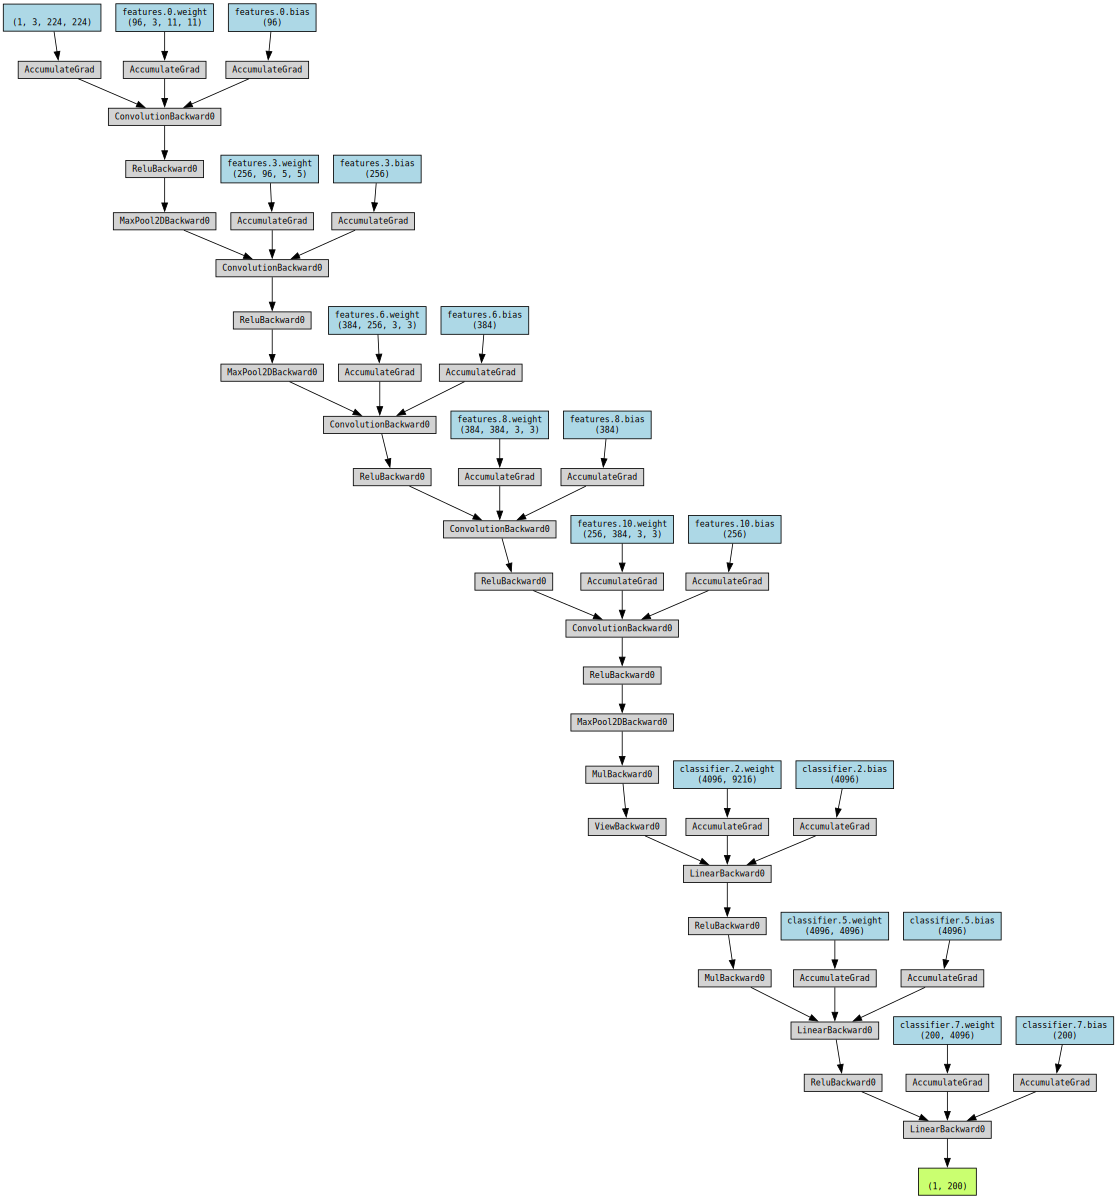

In [7]:
from torchviz import make_dot
import os
os.environ["PATH"] += os.pathsep + '/opt/homebrew/bin'  # M1/M2 Mac

x = torch.rand(1, 3, 224, 224).to(device).requires_grad_(True)
model = net.to(device)
y = model(x)
MyConvNetVis = make_dot(y, params=dict(model.named_parameters()))
MyConvNetVis.format = "png"
MyConvNetVis.render("AlexNet", format="png")
MyConvNetVis

### 5. 对test文件夹中的图片进行预测

In [ ]:
import pandas as pd

# 预测并保存结果
predictions = []

with torch.no_grad():
    for images, paths in ImageNet_test_iter:
        images = images.to(device)
        outputs = net(images)
        _, preds = torch.max(outputs, 1)  # 获取每个样本的预测类别
        for img_path, pred in zip(paths, preds):
            filename = os.path.basename(img_path)
            predictions.append((filename, pred.item()))

# 保存预测结果为 CSV
pred_df = pd.DataFrame(predictions, columns=["Image", "Predicted_Class"])
pred_df.to_csv("test_predictions.csv", index=False)
print("✅ 测试集预测完成，结果已保存为 test_predictions.csv。")


In [ ]:
# 将类别索引映射为类别标签
wnids = [line.strip() for line in open('../Datasets/tiny-imagenet-200/wnids.txt', 'r')]
pred_df["Predicted_Label"] = pred_df["Predicted_Class"].apply(lambda x: wnids[x])
pred_df.to_csv("test_predictions_with_labels.csv", index=False)
print("✅ 已将类别索引映射为标签，结果保存为 test_predictions_with_labels.csv。")

In [ ]:
sample_results = pred_df.sample(9)

fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, (index, row) in enumerate(sample_results.iterrows()):
    img = Image.open(os.path.join('../Datasets/tiny-imagenet-200/test/images', row['Image']))
    axes[i // 3, i % 3].imshow(img)
    axes[i // 3, i % 3].set_title(f"Predicted: {row['Predicted_Label']}")
    axes[i // 3, i % 3].axis('off')

plt.tight_layout()
plt.show()
